In [29]:
from matplotlib import pyplot as plt
import numpy as np

def get_rota_mat(a):
    ''' 
    返回左乘的旋转矩阵,a是逆时针旋转的弧度
    '''
    rota_mat = np.array([[np.cos(a),-np.sin(a)],[np.sin(a),np.cos(a)]])
    return rota_mat

def rotate_points(arr,a):
    ''' 
    把arr逆时针旋转a弧度
    arr是[n*2]的形状
    返回的结果也是n*2的结果
    '''
    rm = get_rota_mat(a)
    arr2 = np.dot(arr,rm.T)
    return arr2


def get_loc_pos_orie(df,tgt_id,nbr_ids,frm_id):
    ''' 
    得到在frm_id时刻，所有车辆的local位置以及orie
    local_pos的第一个总是目标车的位置，后面的就是nbr车辆的位置
    '''
    frm_df = df[(df['frame_id']==frm_id)]
    orie = frm_df[(frm_df['obj_id']==0)]['oritentation_yaw'].values[0]
    
    tgt_pos = frm_df[(frm_df['obj_id']==tgt_id)][['LocalX','LocalY']].values[0]
    local_pos = [tgt_pos]
    for nbr_id in nbr_ids:
        pos = frm_df[(frm_df['obj_id']==nbr_id)][['LocalX','LocalY']].values[0]
        local_pos.append(pos)
    return local_pos,orie

def get_glb_pos_orie(df,tgt_id,nbr_ids,frm_id):
    ''' 
    得到在frm_id时刻，所有车辆的global位置以及orie
    local_pos的第一个总是目标车的位置，后面的就是nbr车辆的位置
    '''
    frm_df = df[(df['frame_id']==frm_id)]
    orie = frm_df[(frm_df['obj_id']==0)]['oritentation_yaw'].values[0]
    
    tgt_pos = frm_df[(frm_df['obj_id']==tgt_id)][['GlobalX','GlobalY']].values[0]
    glb_pos = [tgt_pos]
    for nbr_id in nbr_ids:
        pos = frm_df[(frm_df['obj_id']==nbr_id)][['GlobalX','GlobalY']].values[0]
        glb_pos.append(pos)
    return glb_pos,orie

def get_glb_pos(df,tgt_id,start_frm_id,end_frame_id):
    """
    得到指定帧id之间，指定obj_id的全局轨迹
    """
    return df[(df['frame_id']>=start_frm_id) & (df['frame_id']<=end_frame_id) & (df["obj_id"]==tgt_id)][['GlobalX','GlobalY']].values
    

In [30]:
import pickle

FRM_ID = 1236
DS_ID = 7


In [31]:
with open("ld_data/processed_samples_list/LIDAR_LJ02766_20211203_090337_G290-PDX-007-001-001_000000-000061", "rb") as fp:  # Unpickling
        samples_list = pickle.load(fp)
frm_samples = [i for i in samples_list if i[0]==DS_ID and i[1]==FRM_ID]
frm_samples_id = [36, 0, 11, 40]

ret_dict = {}
ret_dict["frm_id"] = FRM_ID
ret_dict["ds_id"] = DS_ID
ret_dict["hist"] = {}
ret_dict["fut_pred"] = {}

In [32]:
import pandas as pd
csv_path = "ld_data/processed_csvs/LIDAR_LJ02766_20211203_090337_G290-PDX-007-001-001_000000-000061_LD_final_OD_MERGE_OPP_LDE_fusion_10hz.csv"
df = pd.read_csv(csv_path)

TS = df[(df['frame_id']==FRM_ID)]['timestamp'].values[0]
ret_dict['timestamp'] = TS

# 先求得yaw和timestamp
# yaw,ts = df[(df['frame_id']==FRM_ID) & (df['obj_id']==0)][['oritentation_yaw','timestamp']].values[0]
# print(yaw,ts)
# ret_dict["timesatamp"] = ts

In [33]:
def get_frms_dict(df,obj_id,start_frame_id,end_frame_id):
    obj_frms_df = df[(df['frame_id']>=start_frame_id) & (df['frame_id']<=end_frame_id) & (df["obj_id"]==obj_id)][['frame_id','obj_id','timestamp','GlobalX','GlobalY','oritentation_yaw']]
    # print(obj_frms_df)
    json_ex = obj_frms_df.to_dict(orient='records')
    for i in json_ex:
        i['global_pos'] = [i['GlobalX'],i['GlobalY']]
        del i['GlobalX']
        del i['GlobalY']
    return json_ex

# import json
# with open('json_ex.json', 'w', encoding='utf-8') as f:
#     json.dump(json_ex, f, ensure_ascii=False, indent=4)

In [34]:
# 先得到ego车辆的全局坐标
# ego_glb_pos = get_glb_pos(df,0,frm_id-30,frm_id)
# ret_dict['hist'][0] = ego_glb_pos
# # 把每个id的历史轨迹加进去
frm_samples_id = sorted(frm_samples_id)
for id in frm_samples_id:
    id_frms_dict = get_frms_dict(df,id,FRM_ID-30,FRM_ID)
    ret_dict['hist'][id] = id_frms_dict

# # 都减去当前帧ego的坐标，再按照当前帧的ego车辆的yaw角做旋转
# for id,glb_pos in ret_dict['hist'].items():
#     translation_glb_pos = glb_pos-ego_glb_pos[-1]
#     rotate_pos = rotate_points(translation_glb_pos,-yaw)
#     ret_dict['hist'][id] = rotate_pos

import json
print(ret_dict['hist'].keys())
with open('json_ex.json', 'w', encoding='utf-8') as f:
    json.dump(ret_dict, f, ensure_ascii=False, indent=4)
    

dict_keys([0, 11, 36, 40])


In [35]:
for i in range(10):
    print((i+1)*5-1)

4
9
14
19
24
29
34
39
44
49


In [36]:
with open("imgs/ld_eval_imgs/fut_pred_dict/interface_dic1.pkl", "rb") as fp:  # Unpickling
    fut_pred_dict = pickle.load(fp)
# print(sorted(fut_pred_dict[7][5].keys()))

print(fut_pred_dict[7].keys())
ret_dict['fut_pred'] = {}
for obj_id,frm_preds in fut_pred_dict[7].items():
    obj_id = int(obj_id)
    if obj_id == 5:
        continue
    obj_list = []
    for frm_id,frm_pred in frm_preds.items():
        frm_id = int(frm_id)
        if frm_id == FRM_ID:
            # print(frm_id)
            # print(obj_id)
            ref_dict  = get_frms_dict(df,obj_id,frm_id,frm_id)[0]
            ref_pos = ref_dict['global_pos']
            for i in range(10):
                fut_frm_id = frm_id+(i+1)*5
                a = get_frms_dict(df,obj_id,fut_frm_id,fut_frm_id)
                # print(a)
                frm_dict = a[0]
                ts = frm_dict['timestamp']
                fut_pos = frm_pred[0,i,:]
                fut_global_pos = ref_pos + fut_pos
                frm_dict = {'obj_id':obj_id,'frame_id':fut_frm_id,'timestamp':ts,'global_pos':fut_global_pos.tolist()}
                obj_list.append(frm_dict)
            break
    print(obj_list)
    ret_dict['fut_pred'][str(obj_id)] = obj_list


print(ret_dict.keys())
print(ret_dict['hist'].keys())
print(ret_dict['fut_pred'].keys())
# import json
# a = json.dumps(ret_dict,indent=4)
with open('json_ex.json', 'w', encoding='utf-8') as f:
    json.dump(ret_dict, f, ensure_ascii=False, indent=4)

dict_keys([36, 5, 11, 40])
[{'obj_id': 36, 'frame_id': 1241, 'timestamp': 1638522341.415057, 'global_pos': [3626.889927176208, 527.4057641381988]}, {'obj_id': 36, 'frame_id': 1246, 'timestamp': 1638522341.914724, 'global_pos': [3638.7062571322626, 531.8464308137665]}, {'obj_id': 36, 'frame_id': 1251, 'timestamp': 1638522342.4148908, 'global_pos': [3650.2150519168085, 536.2988987321625]}, {'obj_id': 36, 'frame_id': 1256, 'timestamp': 1638522342.91487, 'global_pos': [3660.892019537658, 540.6099968309173]}, {'obj_id': 36, 'frame_id': 1261, 'timestamp': 1638522343.4146528, 'global_pos': [3671.7575857913203, 544.9569607133636]}, {'obj_id': 36, 'frame_id': 1266, 'timestamp': 1638522343.915102, 'global_pos': [3683.5611174380488, 549.4561195726166]}, {'obj_id': 36, 'frame_id': 1271, 'timestamp': 1638522344.414994, 'global_pos': [3695.2649443423456, 553.9540901536712]}, {'obj_id': 36, 'frame_id': 1276, 'timestamp': 1638522344.91485, 'global_pos': [3707.055807379455, 558.3871155137787]}, {'obj_i

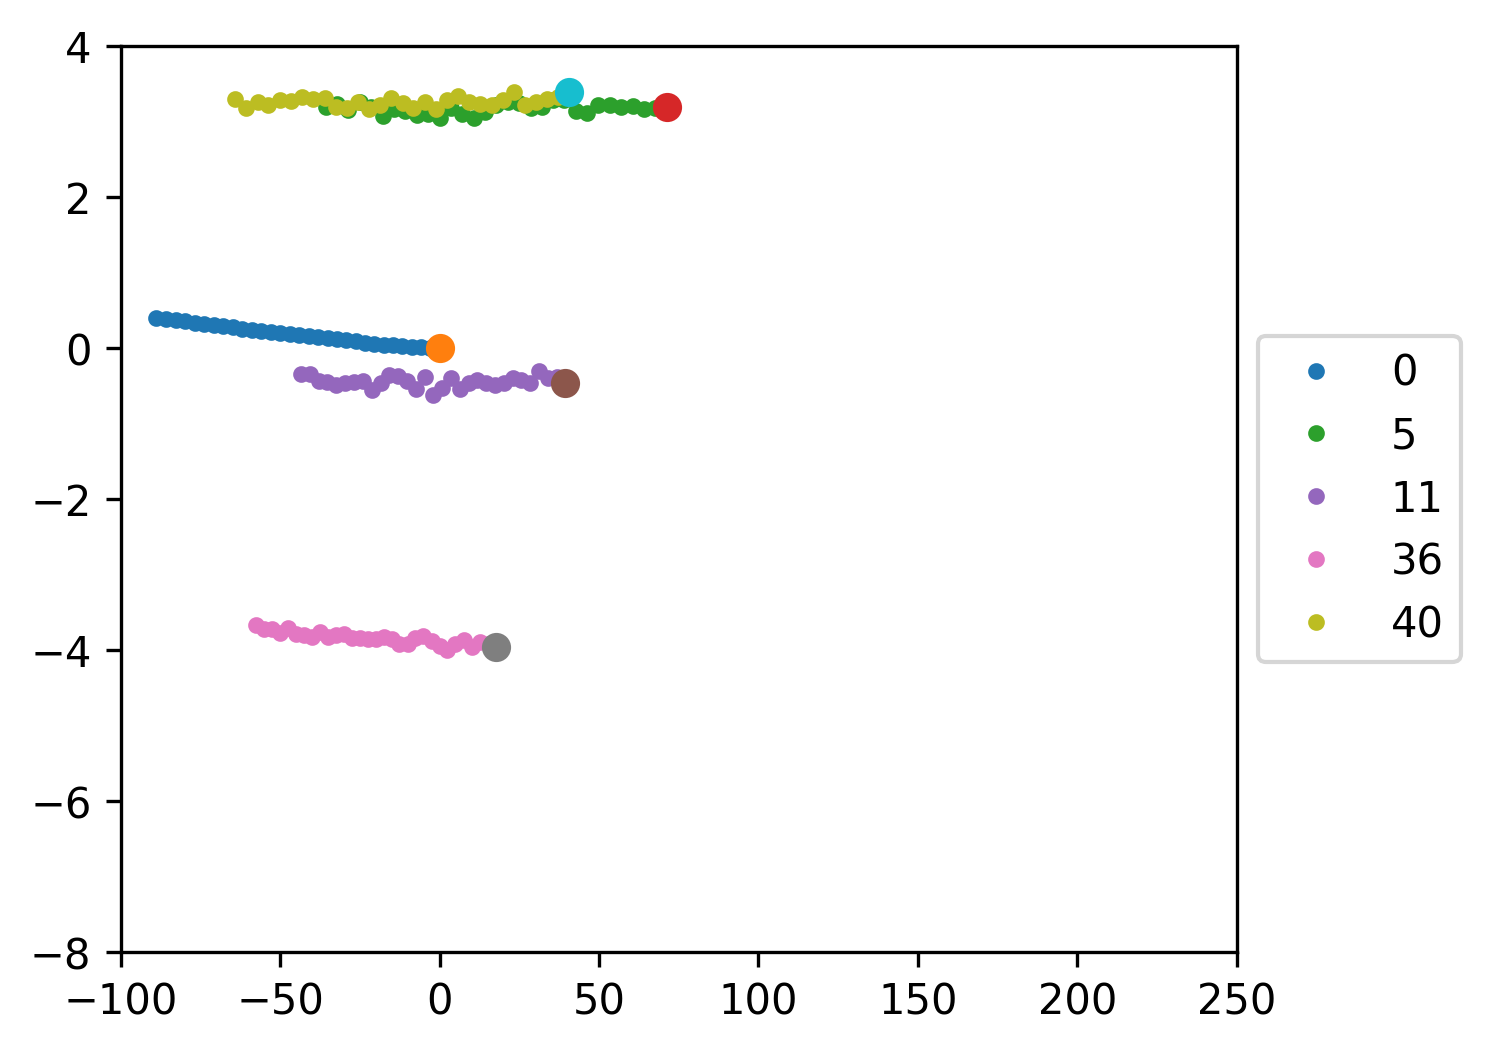

In [33]:
fig, ax = plt.subplots(dpi=300)
plt.xlim(-100,250)
plt.ylim(-8,4)
for id,veh_hist in ret_dict['hist'].items():
    # ax.plot(veh_hist[:,0],veh_hist[:,1],'-', label=id)
    ax.plot(veh_hist[:,0],veh_hist[:,1],'.',label=id)
    ax.plot(veh_hist[-1,0],veh_hist[-1,1],'o')

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# # Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()